In [1]:
import os, sys
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
os.getcwd()

'/workspace/case_study_7'

# DATA 설명 (MNIST, MNIST_CLUTTER)

### mnist data

In [3]:
mnist_data = input_data.read_data_sets("./MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
mnist_data.train.images.shape #-> 55000개의 픽셀 정보 데이터(28x28=784개).

(55000, 784)

In [5]:
mnist_data.train.labels.shape #-> 55000개의 숫자 데이터(각각 1개의 숫자)가 들어가있음.

(55000, 10)

In [6]:
mnist_data.validation.images.shape #-> 5000개의 픽셀 정보 데이터(28x28=784개).

(5000, 784)

In [7]:
mnist_data.validation.labels.shape #-> 5000개의 숫자 데이터(각각 1개의 숫자)가 들어가있음.

(5000, 10)

In [8]:
mnist_data.test.images.shape #-> 10000개의 픽셀 정보 데이터(28x28=784개).

(10000, 784)

In [9]:
mnist_data.test.labels.shape #-> 10000개의 숫자 데이터(각각 1개의 숫자)가 들어가있음.

(10000, 10)

### mnist_clutter data

In [10]:
mnist = np.load('./mnist_sequence1_sample_5distortions5x5.npz')

In [11]:
mnist['X_train'].shape #-> 10000개의 픽셀 정보 데이터(40x40=1600개).

(10000, 1600)

In [12]:
mnist['y_train'].shape #-> 10000개의 숫자 데이터(각각 1개의 숫자)가 들어가있음.

(10000, 1)

In [13]:
mnist['X_valid'].shape #-> 1000개의 픽셀 정보 데이터(40x40=1600개).

(1000, 1600)

In [14]:
mnist['y_valid'].shape #-> 1000개의 숫자 데이터(각각 1개의 숫자)가 들어가있음.

(1000, 1)

In [15]:
mnist['X_test'].shape #-> 1000개의 픽셀 정보 데이터(40x40=1600개).

(1000, 1600)

In [16]:
mnist['y_test'].shape #-> 1000개의 숫자 데이터(각각 1개의 숫자)가 들어가있음.

(1000, 1)

# 1. mnist 데이터로 학습 후 CAM 결과 보기

In [17]:
tr_x = mnist_data.train.images
tr_y = mnist_data.train.labels
val_x = mnist_data.validation.images
val_y = mnist_data.validation.labels
ts_x = mnist_data.test.images
ts_y = mnist_data.test.labels

In [18]:
print(tr_y.shape)
print(val_y.shape)
print(ts_y.shape)

print(tr_y[0])
print(val_y[0])
print(ts_y[0])

(55000, 10)
(5000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [19]:
'''One-hot encoding해줄 필요가 없다.
# One-hot representation function
def one_hot(label):
    enc = OneHotEncoder()
    enc.fit(label)
    res = enc.transform(label).toarray()
    return res
'''

'One-hot encoding해줄 필요가 없다.\n# One-hot representation function\ndef one_hot(label):\n    enc = OneHotEncoder()\n    enc.fit(label)\n    res = enc.transform(label).toarray()\n    return res\n'

In [20]:
'''
# transform
tr_y = one_hot(tr_y)
val_y = one_hot(val_y)
ts_y = one_hot(ts_y)
'''

'\n# transform\ntr_y = one_hot(tr_y)\nval_y = one_hot(val_y)\nts_y = one_hot(ts_y)\n'

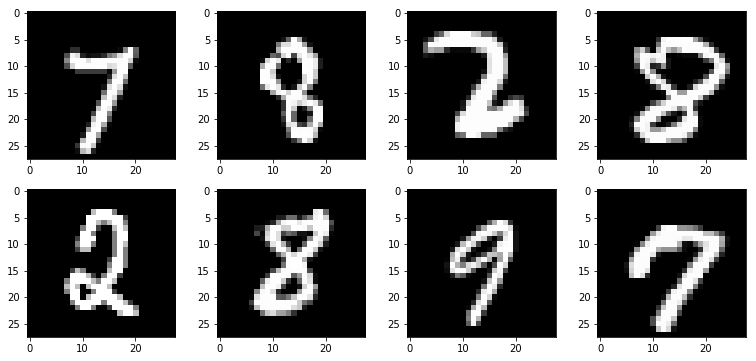

In [21]:
# Visualize mnist cluster dataset
tmp = tr_x.reshape(-1,28,28)
indices = np.random.randint(0, high = tmp.shape[0], size = 8)
fig = plt.figure(figsize = (15,6))
fig.subplots_adjust(right=0.8)
for i, index in enumerate(indices):
    fig.add_subplot(2,4,i+1)
    plt.imshow(tmp[index], cmap = 'gray')

In [22]:
class CNN:
    def __init__(self, activation_fn = tf.nn.relu,
                 initializer = tf.contrib.slim.xavier_initializer_conv2d(),
                 l2_scale = .001):
        
        with tf.variable_scope('input_layer'):
##            self._x = tf.placeholder(dtype = tf.float32, shape = [None, 1600])
            self._x = tf.placeholder(dtype = tf.float32, shape = [None, 784])
##            self._ximg = tf.reshape(tensor = self._x, shape = [-1, 40, 40, 1])
            self._ximg = tf.reshape(tensor = self._x, shape = [-1, 28, 28, 1])
            self._y = tf.placeholder(dtype = tf.float32, shape = [None, 10])
            self._training = tf.placeholder(dtype = tf.bool)
            self._keep_prob = tf.placeholder(dtype = tf.float32)
            
        with tf.contrib.slim.arg_scope([tf.contrib.slim.conv2d], kernel_size = [3,3], padding = 'SAME',
                                       weights_initializer = initializer,
                                       weights_regularizer = tf.contrib.slim.l2_regularizer(scale = l2_scale),
                                       stride = 1):
        
            with tf.variable_scope('conv_layer1'):
                _conv = tf.contrib.slim.conv2d(inputs = self._ximg, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('conv_layer2'):
                _conv = tf.contrib.slim.conv2d(inputs = _conv, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('max_pool1'):
                _pool = tf.contrib.slim.max_pool2d(inputs = _relu, kernel_size = [2,2], stride = 2)
            
            with tf.variable_scope('conv_layer3'):
                _conv = tf.contrib.slim.conv2d(inputs = _pool, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)   
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('conv_layer4'):
                _conv = tf.contrib.slim.conv2d(inputs = _relu, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _relu = tf.nn.relu(features = _conv)
                
            with tf.variable_scope('max_pool2'):
                _pool = tf.contrib.slim.max_pool2d(inputs = _relu, kernel_size = [2,2], stride = 2)

            with tf.variable_scope('conv_layer5'):
                _conv = tf.contrib.slim.conv2d(inputs = _pool, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('conv_layer6'):
                _conv = tf.contrib.slim.conv2d(inputs = _relu, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                self._relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('global_pool'):
##                _pooled = tf.contrib.slim.avg_pool2d(inputs = self._relu, kernel_size = [10,10], stride = 10)
                _pooled = tf.contrib.slim.avg_pool2d(inputs = self._relu, kernel_size = [7,7], stride = 10)
                _pooled = tf.contrib.slim.flatten(inputs = _pooled)
                _pooled = tf.contrib.slim.dropout(inputs = _pooled, keep_prob = self._keep_prob)
                
        with tf.variable_scope('output_layer'):
            self._score = tf.contrib.slim.fully_connected(inputs = _pooled, num_outputs = 10, activation_fn = None,
                                                          weights_initializer = tf.contrib.slim.xavier_initializer(uniform = False),
                                                          weights_regularizer = tf.contrib.slim.l2_regularizer(scale=l2_scale))
        with tf.variable_scope('loss'):
            _ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self._y, logits = self._score))
            _reg_term = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
            self._total_loss = _ce_loss + _reg_term
                
        self._update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.variable_scope('predict'):
            self._prediction = tf.nn.softmax(logits = self._score)
        
    def predict(self, sess, x_data, training = False, keep_prob = 1.):
        feed_predict = {self._x : x_data, self._training : training, self._keep_prob : keep_prob}
        return sess.run(self._prediction, feed_dict = feed_predict)
    
    def extract_featuremap(self, sess, x_data, training = False, keep_prob = 1.):
        feed_featuremap = {self._x : x_data, self._training : training, self._keep_prob : keep_prob}
        return sess.run(self._relu, feed_dict = feed_featuremap)

In [23]:
class Solver:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer, var_list = None):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        
        # Solver class는 model class로부터 생성된 instance를 input으로 받음. model class에서 저장한 객체변수를 아래와 같이 활용
        with tf.control_dependencies(self._model._update_ops):
            self._training_op = self._optimizer.minimize(loss = self._model._total_loss, var_list = var_list)
    
    def train(self, sess, x_data, y_data, lr, training = True, keep_prob = .5):
        feed_train = {self._model._x : x_data, self._model._y : y_data, self._lr : lr,
                      self._model._training : training, self._model._keep_prob : keep_prob}
        return sess.run(fetches = [self._training_op, self._model._total_loss], feed_dict = feed_train)
            
    def evaluate(self, sess, x_data, y_data, training = False, keep_prob = 1.):
        feed_loss = {self._model._x : x_data, self._model._y : y_data, self._model._training : training,
                     self._model._keep_prob : keep_prob}
        return sess.run(fetches = self._model._total_loss, feed_dict = feed_loss)

In [24]:
sess = tf.Session()
clutter_classifier = CNN()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [25]:
adam_solver = Solver(model = clutter_classifier)

In [26]:
# Hyper-parameters
batch_size = 50
n_epochs = 10
tr_loss_history = []
val_loss_history = []

In [27]:
sess.run(tf.global_variables_initializer())

In [28]:
for epoch in range(n_epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    total_batch = int(tr_x.shape[0] / batch_size)
    
    for step in range(total_batch):
        tr_indices = np.random.choice(np.arange(tr_x.shape[0]), size = batch_size, replace=False)
        val_indices = np.random.choice(np.arange(val_x.shape[0]), size = batch_size, replace=False)
        batch_xs = tr_x[tr_indices]
        batch_ys = tr_y[tr_indices]
        val_xs = val_x[val_indices]
        val_ys = val_y[val_indices]
        _, tr_loss = adam_solver.train(sess = sess, x_data = batch_xs, y_data = batch_ys, lr = 1e-3)
        val_loss = adam_solver.evaluate(sess = sess, x_data = val_xs, y_data = val_ys)

        avg_tr_loss += tr_loss / total_batch
        avg_val_loss += val_loss / total_batch
        if step % 50 == 0:
            print('step : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(step, tr_loss, val_loss))

    print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))
    tr_loss_history.append(avg_tr_loss)
    val_loss_history.append(avg_val_loss)

step :   0, tr_loss : 2.503, val_loss : 2.392
step :  50, tr_loss : 1.550, val_loss : 1.909
step : 100, tr_loss : 1.008, val_loss : 0.808
step : 150, tr_loss : 0.805, val_loss : 0.559
step : 200, tr_loss : 0.717, val_loss : 0.540
step : 250, tr_loss : 0.570, val_loss : 0.376
step : 300, tr_loss : 0.688, val_loss : 0.246
step : 350, tr_loss : 0.546, val_loss : 0.242
step : 400, tr_loss : 0.402, val_loss : 0.209
step : 450, tr_loss : 0.512, val_loss : 0.250
step : 500, tr_loss : 0.328, val_loss : 0.169
step : 550, tr_loss : 0.452, val_loss : 0.160
step : 600, tr_loss : 0.355, val_loss : 0.153
step : 650, tr_loss : 0.398, val_loss : 0.214
step : 700, tr_loss : 0.197, val_loss : 0.228
step : 750, tr_loss : 0.380, val_loss : 0.186
step : 800, tr_loss : 0.245, val_loss : 0.125
step : 850, tr_loss : 0.261, val_loss : 0.164
step : 900, tr_loss : 0.267, val_loss : 0.154
step : 950, tr_loss : 0.197, val_loss : 0.209
step : 1000, tr_loss : 0.276, val_loss : 0.111
step : 1050, tr_loss : 0.179, val

step : 850, tr_loss : 0.109, val_loss : 0.072
step : 900, tr_loss : 0.112, val_loss : 0.071
step : 950, tr_loss : 0.194, val_loss : 0.113
step : 1000, tr_loss : 0.108, val_loss : 0.198
step : 1050, tr_loss : 0.228, val_loss : 0.112
epoch :   7, tr_loss : 0.150, val_loss : 0.105
step :   0, tr_loss : 0.197, val_loss : 0.176
step :  50, tr_loss : 0.143, val_loss : 0.096
step : 100, tr_loss : 0.426, val_loss : 0.073
step : 150, tr_loss : 0.273, val_loss : 0.162
step : 200, tr_loss : 0.119, val_loss : 0.097
step : 250, tr_loss : 0.107, val_loss : 0.071
step : 300, tr_loss : 0.113, val_loss : 0.072
step : 350, tr_loss : 0.118, val_loss : 0.080
step : 400, tr_loss : 0.104, val_loss : 0.074
step : 450, tr_loss : 0.090, val_loss : 0.071
step : 500, tr_loss : 0.189, val_loss : 0.088
step : 550, tr_loss : 0.122, val_loss : 0.077
step : 600, tr_loss : 0.202, val_loss : 0.076
step : 650, tr_loss : 0.152, val_loss : 0.153
step : 700, tr_loss : 0.111, val_loss : 0.073
step : 750, tr_loss : 0.277, va

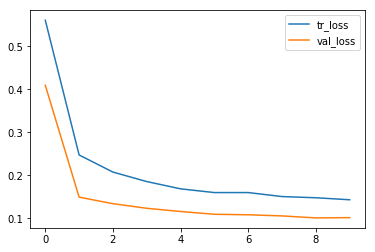

In [29]:
plt.plot(tr_loss_history, label = 'tr_loss')
plt.plot(val_loss_history, label = 'val_loss')
plt.legend()

In [30]:
hat = clutter_classifier.predict(sess = sess, x_data = ts_x)

In [31]:
print('Accuracy : {:.2%}'.format(np.mean(np.argmax(hat, axis = 1) == np.argmax(ts_y, axis = 1))))

Accuracy : 99.23%


In [32]:
weights = sess.run(tf.get_collection(tf.GraphKeys.MODEL_VARIABLES, scope = 'output_layer')[0])
def cam(featuremap, weights, pred_class):
    pred_weights = weights[:,pred_class]
    output = np.zeros(featuremap.shape[1:3])
    
    for channel in range(weights.shape[0]):
        output += pred_weights[channel] * featuremap[0,:,:,channel] 
    output /= weights.shape[0]
##    output = resize(output, output_shape = [40,40], mode = 'reflect')
    output = resize(output, output_shape = [28,28], mode = 'reflect')
    output = (output - np.min(output)) / (np.max(output) - np.min(output))
    plt.imshow(output, cmap = 'jet', interpolation = 'bilinear')

Text(0.5,1,'3 is True label, 3 is prediction')

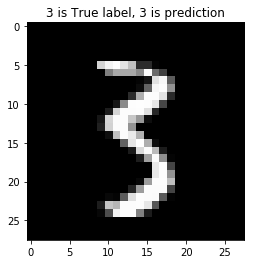

In [33]:
target_index = np.random.choice(np.arange(ts_y.shape[0]), size = 1)
hat = clutter_classifier.predict(sess = sess, x_data = ts_x[target_index])
##plt.imshow(ts_x[target_index].reshape(40,40), cmap = 'gray')
plt.imshow(ts_x[target_index].reshape(28,28), cmap = 'gray')
plt.title('{} is True label, {} is prediction'.format(np.argmax(ts_y[target_index]),np.argmax(hat)))

In [34]:
featuremap = clutter_classifier.extract_featuremap(sess = sess, x_data = ts_x[target_index])

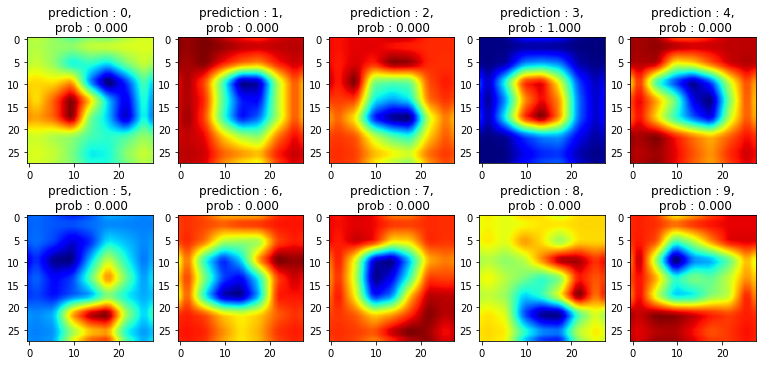

In [35]:
fig = plt.figure(figsize = (15, 6))
fig.subplots_adjust(right = .8)
for pred_class, pred_prob in enumerate(hat.flatten()):
    fig.add_subplot(2,5, pred_class + 1)
    cam(featuremap, weights, pred_class)
    plt.title('prediction : {},\n prob : {:.3f}'.format(pred_class, pred_prob))

# 2. 1번 모델에 mnist clutter 데이터로 CAM 결과 보기

In [36]:
ts_x = mnist['X_test']
ts_y = mnist['y_test']

In [37]:
print(ts_x.shape)
print(ts_y.shape)

(1000, 1600)
(1000, 1)


In [38]:
delete_list = [0,1,2, 7, 12, 17, 22, 27, 32, 37,38,39]

tmp_list = np.ndarray(shape=(1, 784))
print(tmp_list[0].shape)

(784,)


In [39]:
for i in range(1000):
    reshape_mat=ts_x[i].reshape((40,40))
    reshape_mat1=np.delete(reshape_mat, delete_list, 0)
    reshape_mat2=np.delete(reshape_mat1, delete_list, 1)
    reshape_mat3=reshape_mat2.reshape(1,784)
    print(tmp_list.shape, reshape_mat3.shape)
    tmp_list = np.vstack((tmp_list, reshape_mat3))

(1, 784) (1, 784)
(2, 784) (1, 784)
(3, 784) (1, 784)
(4, 784) (1, 784)
(5, 784) (1, 784)
(6, 784) (1, 784)
(7, 784) (1, 784)
(8, 784) (1, 784)
(9, 784) (1, 784)
(10, 784) (1, 784)
(11, 784) (1, 784)
(12, 784) (1, 784)
(13, 784) (1, 784)
(14, 784) (1, 784)
(15, 784) (1, 784)
(16, 784) (1, 784)
(17, 784) (1, 784)
(18, 784) (1, 784)
(19, 784) (1, 784)
(20, 784) (1, 784)
(21, 784) (1, 784)
(22, 784) (1, 784)
(23, 784) (1, 784)
(24, 784) (1, 784)
(25, 784) (1, 784)
(26, 784) (1, 784)
(27, 784) (1, 784)
(28, 784) (1, 784)
(29, 784) (1, 784)
(30, 784) (1, 784)
(31, 784) (1, 784)
(32, 784) (1, 784)
(33, 784) (1, 784)
(34, 784) (1, 784)
(35, 784) (1, 784)
(36, 784) (1, 784)
(37, 784) (1, 784)
(38, 784) (1, 784)
(39, 784) (1, 784)
(40, 784) (1, 784)
(41, 784) (1, 784)
(42, 784) (1, 784)
(43, 784) (1, 784)
(44, 784) (1, 784)
(45, 784) (1, 784)
(46, 784) (1, 784)
(47, 784) (1, 784)
(48, 784) (1, 784)
(49, 784) (1, 784)
(50, 784) (1, 784)
(51, 784) (1, 784)
(52, 784) (1, 784)
(53, 784) (1, 784)
(5

(834, 784) (1, 784)
(835, 784) (1, 784)
(836, 784) (1, 784)
(837, 784) (1, 784)
(838, 784) (1, 784)
(839, 784) (1, 784)
(840, 784) (1, 784)
(841, 784) (1, 784)
(842, 784) (1, 784)
(843, 784) (1, 784)
(844, 784) (1, 784)
(845, 784) (1, 784)
(846, 784) (1, 784)
(847, 784) (1, 784)
(848, 784) (1, 784)
(849, 784) (1, 784)
(850, 784) (1, 784)
(851, 784) (1, 784)
(852, 784) (1, 784)
(853, 784) (1, 784)
(854, 784) (1, 784)
(855, 784) (1, 784)
(856, 784) (1, 784)
(857, 784) (1, 784)
(858, 784) (1, 784)
(859, 784) (1, 784)
(860, 784) (1, 784)
(861, 784) (1, 784)
(862, 784) (1, 784)
(863, 784) (1, 784)
(864, 784) (1, 784)
(865, 784) (1, 784)
(866, 784) (1, 784)
(867, 784) (1, 784)
(868, 784) (1, 784)
(869, 784) (1, 784)
(870, 784) (1, 784)
(871, 784) (1, 784)
(872, 784) (1, 784)
(873, 784) (1, 784)
(874, 784) (1, 784)
(875, 784) (1, 784)
(876, 784) (1, 784)
(877, 784) (1, 784)
(878, 784) (1, 784)
(879, 784) (1, 784)
(880, 784) (1, 784)
(881, 784) (1, 784)
(882, 784) (1, 784)
(883, 784) (1, 784)


In [40]:
print(tmp_list.shape)
print(tmp_list[1:].shape)

(1001, 784)
(1000, 784)


In [41]:
ts_x = tmp_list[1:]

print(type(ts_x))
print(ts_x.shape)

<class 'numpy.ndarray'>
(1000, 784)


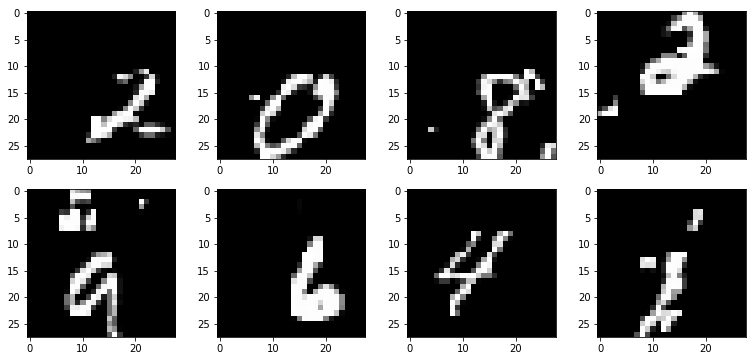

In [42]:
# Visualize mnist cluster dataset
tmp = ts_x.reshape(-1,28,28)
indices = np.random.randint(0, high = tmp.shape[0], size = 8)
fig = plt.figure(figsize = (15,6))
fig.subplots_adjust(right=0.8)
for i, index in enumerate(indices):
    fig.add_subplot(2,4,i+1)
    plt.imshow(tmp[index], cmap = 'gray')

In [43]:
# One-hot representation function
def one_hot(label):
    enc = OneHotEncoder()
    enc.fit(label)
    res = enc.transform(label).toarray()
    return res

In [44]:
# transform
tr_y = one_hot(tr_y)
val_y = one_hot(val_y)
ts_y = one_hot(ts_y)

In [45]:
hat = clutter_classifier.predict(sess = sess, x_data = ts_x)

In [46]:
print('Accuracy : {:.2%}'.format(np.mean(np.argmax(hat, axis = 1) == np.argmax(ts_y, axis = 1))))

Accuracy : 87.00%


In [47]:
weights = sess.run(tf.get_collection(tf.GraphKeys.MODEL_VARIABLES, scope = 'output_layer')[0])
def cam(featuremap, weights, pred_class):
    pred_weights = weights[:,pred_class]
    output = np.zeros(featuremap.shape[1:3])
    
    for channel in range(weights.shape[0]):
        output += pred_weights[channel] * featuremap[0,:,:,channel] 
    output /= weights.shape[0]
##    output = resize(output, output_shape = [40,40], mode = 'reflect')
    output = resize(output, output_shape = [28,28], mode = 'reflect')
    output = (output - np.min(output)) / (np.max(output) - np.min(output))
    plt.imshow(output, cmap = 'jet', interpolation = 'bilinear')

Text(0.5,1,'0 is True label, 0 is prediction')

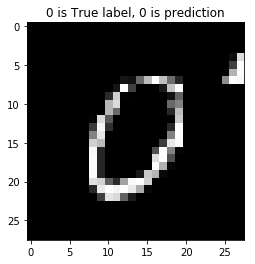

In [48]:
target_index = np.random.choice(np.arange(ts_y.shape[0]), size = 1)
hat = clutter_classifier.predict(sess = sess, x_data = ts_x[target_index])
##plt.imshow(ts_x[target_index].reshape(40,40), cmap = 'gray')
plt.imshow(ts_x[target_index].reshape(28,28), cmap = 'gray')
plt.title('{} is True label, {} is prediction'.format(np.argmax(ts_y[target_index]),np.argmax(hat)))

In [49]:
featuremap = clutter_classifier.extract_featuremap(sess = sess, x_data = ts_x[target_index])

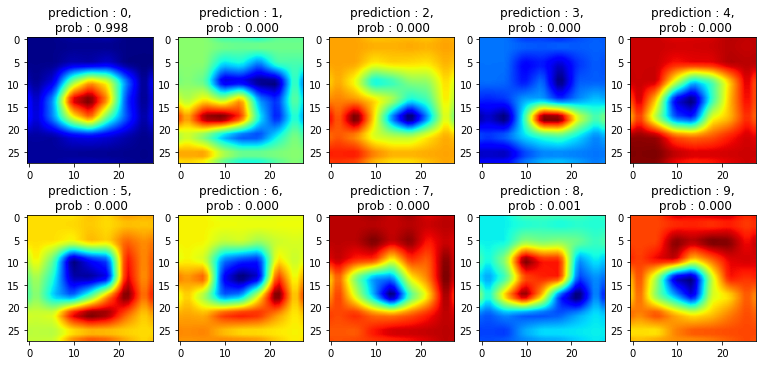

In [50]:
fig = plt.figure(figsize = (15, 6))
fig.subplots_adjust(right = .8)
for pred_class, pred_prob in enumerate(hat.flatten()):
    fig.add_subplot(2,5, pred_class + 1)
    cam(featuremap, weights, pred_class)
    plt.title('prediction : {},\n prob : {:.3f}'.format(pred_class, pred_prob))